<a href="https://colab.research.google.com/github/rajendradayma/AI-fitness-Chatbots/blob/main/Qwen_LLM_using_a_different_conversation_dataset(english_quotes).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q transformers peft accelerate datasets bitsandbytes trl matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.3/366.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [22]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt
import os

In [3]:
dataset = load_dataset("Abirate/english_quotes")  # you can change this
dataset = dataset["train"].train_test_split(test_size=0.1)
train_data = dataset["train"]
eval_data = dataset["test"]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

quotes.jsonl:   0%|          | 0.00/647k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

In [4]:
model_id = "Qwen/Qwen1.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True,
    device_map="auto",
    trust_remote_code=True
)

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

In [5]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [6]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

In [7]:
def tokenize(example):
    return tokenizer(example["quote"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(tokenize, batched=True)
eval_data = eval_data.map(tokenize, batched=True)

Map:   0%|          | 0/2257 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

In [8]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [12]:
training_args = TrainingArguments(
    output_dir="./qwen2.5-lora",
    eval_strategy="steps",
    eval_steps=100,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
    save_steps=100,
    fp16=True,
    report_to="none"
)

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator
)

<ipython-input-10-2641879322>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [11]:
train_result = trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:463: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we wi

Step,Training Loss,Validation Loss
100,3.209600,3.360951
200,3.096100,3.286981
300,3.285900,3.256965
400,2.947500,3.245257
500,3.020400,3.231754
600,3.077500,3.229174
700,3.035600,3.223951
800,3.033800,3.222302


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

In [13]:
peft_path = "./qwen2.5-lora-adapter"
model.save_pretrained(peft_path)
tokenizer.save_pretrained(peft_path)

('./qwen2.5-lora-adapter/tokenizer_config.json',
 './qwen2.5-lora-adapter/special_tokens_map.json',
 './qwen2.5-lora-adapter/chat_template.jinja',
 './qwen2.5-lora-adapter/vocab.json',
 './qwen2.5-lora-adapter/merges.txt',
 './qwen2.5-lora-adapter/added_tokens.json',
 './qwen2.5-lora-adapter/tokenizer.json')

In [14]:
full_model_path = "./qwen2.5-lora-full"
model.base_model.save_pretrained(full_model_path)
tokenizer.save_pretrained(full_model_path)
print("✅ Saved both LoRA adapter and full model.")

('./qwen2.5-lora-full/tokenizer_config.json',
 './qwen2.5-lora-full/special_tokens_map.json',
 './qwen2.5-lora-full/chat_template.jinja',
 './qwen2.5-lora-full/vocab.json',
 './qwen2.5-lora-full/merges.txt',
 './qwen2.5-lora-full/added_tokens.json',
 './qwen2.5-lora-full/tokenizer.json')

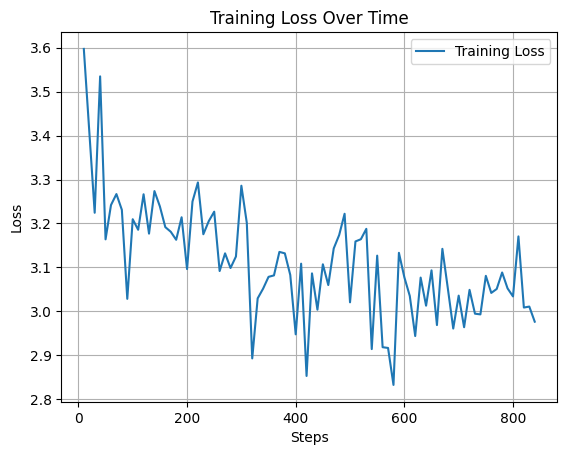

In [15]:
loss_values = trainer.state.log_history
steps = [log["step"] for log in loss_values if "loss" in log]
losses = [log["loss"] for log in loss_values if "loss" in log]

plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.savefig("train_loss_plot.png")
plt.show()

In [17]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

# ✅ Load LoRA model
base_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B", device_map="auto", load_in_4bit=True, trust_remote_code=True)
model = PeftModel.from_pretrained(base_model, "./qwen2.5-lora-adapter")
tokenizer = AutoTokenizer.from_pretrained("./qwen2.5-lora-adapter", trust_remote_code=True)

# ✅ Prepare prompt
prompt = "<|im_start|>user\nHow do I improve my Python skills?<|im_end|>\n<|im_start|>assistant\n"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# ✅ Generate
outputs = model.generate(
    inputs["input_ids"],
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id
)

# ✅ Decode & Print
response = tokenizer.decode(outputs[0], skip_special_tokens=False)
final = response.split("<|im_start|>assistant\n")[-1].split("<|im_end|>")[0]
print("\n🧠 Assistant's Response:\n", final)

# ✅ Manual rating
print("→ Rate on: Relevance ⭐ | Coherence ⭐ | Helpfulness ⭐ (1–5 stars)")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



🧠 Assistant's Response:
 There are many ways to improve your Python skills. Here are some of the easiest ones:

1. Read the documentation: The official documentation is a great place to start reading Python. It's always better to read the documentation than trying to write your own program.

2. Learn the basics: It's important to start learning the basics of Python, such as variables, lists, strings, etc. Once you have a good understanding of these basic concepts, you can start learning more advanced Python.

3.
→ Rate on: Relevance ⭐ | Coherence ⭐ | Helpfulness ⭐ (1–5 stars)


In [21]:
from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForCausalLM

# ✅ Load LoRA model
base_model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen1.5-0.5B", device_map="auto", load_in_4bit=True, trust_remote_code=True)
model = PeftModel.from_pretrained(base_model, "./qwen2.5-lora-adapter")
tokenizer = AutoTokenizer.from_pretrained("./qwen2.5-lora-adapter", trust_remote_code=True)

# ✅ Prepare prompt
prompt = "<|im_start|>user\nhow to learn fine tune llm model and expiain every step ?<|im_end|>\n<|im_start|>assistant\n"
inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

# ✅ Generate
outputs = model.generate(
    inputs["input_ids"],
    max_new_tokens=512,
    temperature=0.7,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id
)

# ✅ Decode & Print
response = tokenizer.decode(outputs[0], skip_special_tokens=False)
final = response.split("<|im_start|>assistant\n")[-1].split("<|im_end|>")[0]
print("\n🧠 Assistant's Response:\n", final)

# ✅ Manual rating
print("→ Rate on: Relevance ⭐ | Coherence ⭐ | Helpfulness ⭐ (1–5 stars)")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.



🧠 Assistant's Response:
 It's a good idea to start with small datasets and slowly raise the difficulty of the model. The main reason is that many times you can't improve the model with a small dataset, because you need to try to fit a large number of models and find the best one. So the best way to learn is to try to fit the best models (and you can have a try with your own models). You can do this by creating a new data set and splitting it into training and testing. Then, you can train the model for a few days and then try to fit it with a new dataset. If you've fitted the model with a good performance, then you should be able to give you the best possible performance with the new data. If you are having trouble with the model, then you might need to try to get better at the data by fitting with a different dataset (or even something completely different).
→ Rate on: Relevance ⭐ | Coherence ⭐ | Helpfulness ⭐ (1–5 stars)


In [24]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=89c079dff89b411848181950de5e2818e3ff0a637641852ab8bdf5f7acea7b30
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


In [27]:
import evaluate
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# === Your model and tokenizer ===
model_path = "./qwen2.5-lora-adapter"  # or wherever your LoRA model is
model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).cuda()
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

# === Predictions and References ===
predictions = [
    "You should practice coding regularly and work on projects to improve your Python skills.",
    "AI will help improve diagnostics and efficiency in healthcare systems."
]
references = [
    ["To improve Python skills, practice coding daily, read documentation, and build projects."],
    ["AI in healthcare can automate diagnostics, personalize treatments, and reduce costs."]
]

# === ROUGE ===
rouge = evaluate.load("rouge")
rouge_scores = rouge.compute(predictions=predictions, references=[ref[0] for ref in references])
print("📊 ROUGE:", rouge_scores)

# === BLEU ===
bleu = evaluate.load("bleu")
bleu_scores = bleu.compute(predictions=predictions, references=references)
print("📊 BLEU:", bleu_scores)

# === Perplexity Calculation ===
def calculate_perplexity(model, tokenizer, texts):
    model.eval()
    losses = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs, labels=inputs["input_ids"])
            loss = outputs.loss
            losses.append(loss.item())
    mean_loss = np.mean(losses)
    perplexity = np.exp(mean_loss)
    return perplexity

perplexity = calculate_perplexity(model, tokenizer, [ref[0] for ref in references])
print("📉 Perplexity:", perplexity)


📊 ROUGE: {'rouge1': np.float64(0.5457875457875457), 'rouge2': np.float64(0.1776315789473684), 'rougeL': np.float64(0.29670329670329665), 'rougeLsum': np.float64(0.29670329670329665)}
📊 BLEU: {'bleu': 0.0, 'precisions': [0.5384615384615384, 0.125, 0.0, 0.0], 'brevity_penalty': 0.8574039191604413, 'length_ratio': 0.8666666666666667, 'translation_length': 26, 'reference_length': 30}
📉 Perplexity: 41.0253335699438


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Map:   0%|          | 0/2257 [00:00<?, ? examples/s]

Map:   0%|          | 0/251 [00:00<?, ? examples/s]

<ipython-input-29-1532488572>:70: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWar

Epoch,Training Loss,Validation Loss
1,3.457400,3.508746
2,3.445800,3.454726
3,3.341600,3.409549
4,3.319000,3.378412
5,3.299000,3.357586
6,3.251800,3.343786
7,3.260800,3.334344
8,3.231700,3.328166
9,3.229300,3.324497
10,3.211000,3.323419


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/

✅ LoRA adapter and full model saved.


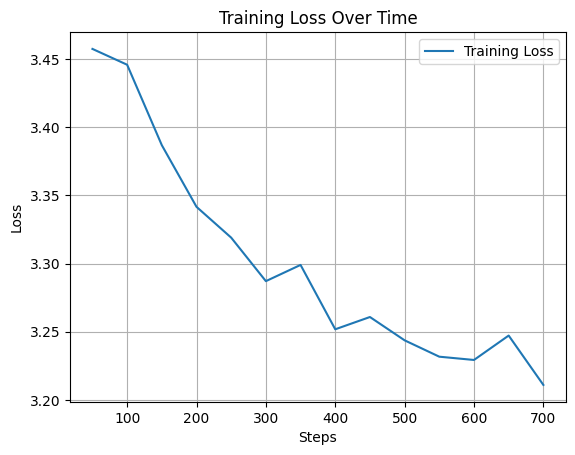

In [29]:

!pip install -q transformers peft accelerate datasets bitsandbytes trl matplotlib evaluate


import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import matplotlib.pyplot as plt
import evaluate
import os
import math

#  Load dataset
dataset = load_dataset("Abirate/english_quotes")
dataset = dataset["train"].train_test_split(test_size=0.1)
train_data = dataset["train"]
eval_data = dataset["test"]

#  Tokenizer and model
model_id = "Qwen/Qwen1.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    load_in_4bit=True,
    device_map="auto",
    trust_remote_code=True
)

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

#  LoRA config
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)

#  Tokenize
def tokenize(example):
    return tokenizer(example["quote"], truncation=True, padding="max_length", max_length=128)

train_data = train_data.map(tokenize, batched=True)
eval_data = eval_data.map(tokenize, batched=True)

#  Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#  Training args
training_args = TrainingArguments(
    output_dir="./qwen2.5-lora",
    eval_strategy="epoch",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=1e-5,
    logging_dir="./logs",
    logging_steps=50,
    save_total_limit=2,
    save_strategy="epoch",
    fp16=True,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=eval_data,
    tokenizer=tokenizer,
    data_collator=data_collator
)

#
train_result = trainer.train()

#  Save adapter and full model
model.save_pretrained("./qwen2.5-lora-adapter")
tokenizer.save_pretrained("./qwen2.5-lora-adapter")
model.base_model.save_pretrained("./qwen2.5-lora-full")

print("LoRA adapter and full model saved.")


loss_values = trainer.state.log_history
steps = [log["step"] for log in loss_values if "loss" in log]
losses = [log["loss"] for log in loss_values if "loss" in log]

plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.savefig("train_loss_plot.png")
plt.show()


In [32]:
# Sample prompts & references
prompts = ["How can I improve my Python skills?"]
references = ["To improve Python skills, practice coding daily, read documentation, and build projects."]

predictions = []
for prompt in prompts:
    input_ids = tokenizer(prompt, return_tensors="pt").to(model.device)
    output = model.generate(input_ids.input_ids,
                            max_new_tokens=100,
                            pad_token_id=tokenizer.eos_token_id)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append(decoded)

# Perplexity
from torch.nn import CrossEntropyLoss
def calculate_perplexity(text):
    encodings = tokenizer(text, return_tensors="pt").to(model.device)
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids=input_ids)
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = target_ids[..., 1:].contiguous()
        loss_fct = CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        return math.exp(loss.item())

print("📉 Perplexity:", calculate_perplexity(" ".join(prompts)))

# ROUGE
rouge = evaluate.load("rouge")
rouge_result = rouge.compute(predictions=predictions, references=references)
print("📊 ROUGE:", rouge_result)

# BLEU
bleu = evaluate.load("bleu")
bleu_result = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
print("📊 BLEU:", bleu_result)


📉 Perplexity: 19.3973097204191
📊 ROUGE: {'rouge1': np.float64(0.12903225806451613), 'rouge2': np.float64(0.04395604395604396), 'rougeL': np.float64(0.12903225806451613), 'rougeLsum': np.float64(0.10752688172043011)}
📊 BLEU: {'bleu': 0.0, 'precisions': [0.07, 0.020202020202020204, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 6.25, 'translation_length': 100, 'reference_length': 16}


In [36]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM


model_id = "Qwen/Qwen1.5-0.5B"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, device_map="auto")


tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id


prompts = [
    "What is the future of AI in healthcare?",
    "Explain the concept of attention mechanism in transformers.",
    "How can I get started with machine learning?",
    "What are the best practices for clean code?",
    "Describe the Turing Test and its relevance today.",
    "What is overfitting in machine learning?",
    "Explain the differences between supervised and unsupervised learning.",
    "How does natural language processing work?",
    "What are generative models used for?",
    "Explain reinforcement learning with an example."
]


responses = []
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=100,
        pad_token_id=pad_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    responses.append((prompt, response.strip()))


for i, (prompt, response) in enumerate(responses):
    print(f"\n Prompt {i+1}: {prompt}")
    print(f" Model Response:\n{response}")
    print(f" Human Evaluation - Please rate 1 to 5:")
    print("• Fluency: __\n• Coherence: __\n• Relevance: __\n" + "-"*60)



🧠 Prompt 1: What is the future of AI in healthcare?
💬 Model Response:
What is the future of AI in healthcare? AI will play a major role in healthcare in the future. AI is already being used to improve diagnosis, medical imaging, drug discovery, and patient care. AI can help doctors make more accurate diagnoses, automate routine tasks, and provide personalized treatment plans. In addition, AI can help identify patients at risk for certain diseases or conditions, speed up procedures, and reduce costs for patients and healthcare systems. As AI technology continues to advance, the possibilities for healthcare are endless, and AI has the potential to revolution
🔍 Human Evaluation - Please rate 1 to 5:
• Fluency: __
• Coherence: __
• Relevance: __
------------------------------------------------------------

🧠 Prompt 2: Explain the concept of attention mechanism in transformers.
💬 Model Response:
Explain the concept of attention mechanism in transformers. Attention mechanism is a technique 

In [37]:
#  Required Imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load Model and Tokenizer (Qwen)
model_id = "./qwen2.5-lora-adapter"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, device_map="auto")

#  Set pad_token_id
tokenizer.pad_token = tokenizer.eos_token
pad_token_id = tokenizer.pad_token_id

#  Example Prompts
prompts = [
    "What is the future of AI in healthcare?",
    "Explain the concept of attention mechanism in transformers.",
    "How can I get started with machine learning?",
    "What are the best practices for clean code?",
    "Describe the Turing Test and its relevance today.",
    "What is overfitting in machine learning?",
    "Explain the differences between supervised and unsupervised learning.",
    "How does natural language processing work?",
    "What are generative models used for?",
    "Explain reinforcement learning with an example."
]

#  Generate Responses
responses = []
for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=100,
        pad_token_id=pad_token_id,
        do_sample=True,
        top_k=50,
        top_p=0.95
    )
    response = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    responses.append((prompt, response.strip()))

#  Display for Manual Human Evaluation
for i, (prompt, response) in enumerate(responses):
    print(f"\n🧠 Prompt {i+1}: {prompt}")
    print(f"💬 Model Response:\n{response}")
    print(f"🔍 Human Evaluation - Please rate 1 to 5:")
    print("• Fluency: __\n• Coherence: __\n• Relevance: __\n" + "-"*60)



🧠 Prompt 1: What is the future of AI in healthcare?
💬 Model Response:
What is the future of AI in healthcare? The future of AI in healthcare is bright. In recent years, AI has started to become a game changer in healthcare, from improving the accuracy of medical diagnoses to speeding up the drug discovery process. AI has the potential to revolutionize the way we approach healthcare by bringing together data from various sources in a more efficient and accurate way.

One of the key advantages of AI in healthcare is its ability to analyze vast amounts of medical data in real-time. This can help doctors and researchers identify patterns and trends that
🔍 Human Evaluation - Please rate 1 to 5:
• Fluency: __
• Coherence: __
• Relevance: __
------------------------------------------------------------

🧠 Prompt 2: Explain the concept of attention mechanism in transformers.
💬 Model Response:
Explain the concept of attention mechanism in transformers. Attention mechanism in transformers is the

In [40]:
import shutil

# Zip the LoRA adapter
shutil.make_archive('qwen2.5-lora-adapter', 'zip', './qwen2.5-lora-adapter')

# Zip the full model
shutil.make_archive('qwen2.5-lora-full', 'zip', './qwen2.5-lora-full')


'/content/qwen2.5-lora-full.zip'